# MOM6 input file idealised case

In [22]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

In [23]:
# First define grid
NI, NJ, NK = 800, 400, 2 # number of points in zonal, meridional and vertical levels
LENLON, LENLAT = 3200., 1600. # in km 
MAXIMUM_DEPTH = 4000.   # in m 
WESTLON, SOUTHLAT = 0.0, 0.0

X = np.linspace(WESTLON, WESTLON + LENLON - 0*LENLON/NI, NI)
Y = np.linspace(SOUTHLAT, SOUTHLAT + LENLAT - 0*LENLAT/NJ, NJ)
#Z = [k for k in range(NK)]

Xm, Ym = np.meshgrid(X,Y)

In [44]:
def flat_bottom():
    D = MAXIMUM_DEPTH*np.ones((NJ,NI))
    return D

def Navid_ridge_bottom(H0, sigma):
    D = MAXIMUM_DEPTH*np.ones((NJ,NI))
    ridge = np.exp(-((Xm - LENLON/6)/sigma)**2) + np.exp(-((Xm - 2*LENLON/6)/sigma)**2) \
    + np.exp(-((Xm - 3*LENLON/6)/sigma)**2) + np.exp(-((Xm - 4*LENLON/6)/sigma)**2) \
    + np.exp(-((Xm - 5*LENLON/6)/sigma)**2)
    ridge = ridge*H0/np.max(ridge)
    D = D - ridge
    return D

def guassian_ridge_bottom(H0, sigma):
    D = MAXIMUM_DEPTH*np.ones((NJ,NI))
    ridge = np.exp(-((Xm - LENLON/2)/sigma)**2)
    ridge = ridge*H0/np.max(ridge)
    D = D - ridge
    return D

def zero_velocity():
    u = np.zeros((NK,NJ,NI))
    v = np.zeros((NK,NJ,NI))
    return u,v

def wind_stress(tau_0):
    taux = tau_0*np.sin(np.pi*Ym/LENLAT)**2
    tauy = np.zeros((NJ,NI))
    return taux, tauy

def wind_stress_Navid(tau_0):
    taux = tau_0*np.sin(np.pi*(Ym - 0*LENLAT/4.)/(3*LENLAT/4))**2
    taux[int(np.round(3*NJ/4)):,:] = 0.
    tauy = np.zeros((NJ,NI))
    return taux, tauy


# Returns an array h[k,j,i] representing the layer thickness of the k-th layer at (lat,lon) 
# and an array eta[k,j,i] with the heights of each interface.
# Note that h has NK values in the vertical while eta has NK+1 values.
# k = 0 is the surface layer, with increasing k descending down the layers.
# h[i,j,k] >= ANGSTROM, which is the minimum layer thickness.
# input : D[i,j], a two-dimensional array of the depth of the ocean.
def layer_thickness(eta0, depth):
    eta = np.zeros((NK+1,NJ,NI))
    h = np.zeros((NK,NJ,NI))
    
    eta[NK-1,:,:] = -MAXIMUM_DEPTH/4.
    eta[NK,:,:] = - depth
    
    for k in range(0,NK):
        h[k,:,:] = eta[k,:,:] - eta[k+1,:,:]
        
    return h, eta

In [45]:
tau_0 = 0.15

ridge_h0 = 400.
sigma = 1000.
H1, H2 = (2000., 2000.)

Rd = 20000
f = -10**-4
gp = Rd**2*MAXIMUM_DEPTH*f**2/(H1*H2)

rho_0 = 1031.0
rho_1 = gp*rho_0/9.8 + rho_0

density = [1031.0, rho_1]

print(gp, density)

#depth = guassian_ridge_bottom(ridge_h0, sigma)
depth = Navid_ridge_bottom(ridge_h0, 100)
taux, tauy = wind_stress_Navid(tau_0)

eta0 = [0., -MAXIMUM_DEPTH/2., -MAXIMUM_DEPTH]
h, eta = layer_thickness(eta0, depth)

0.004 [1031.0, 1031.4208163265307]


In [46]:
print(h.shape, eta.shape)
print(density)
print(eta[2,:,:])

(2, 400, 800) (3, 400, 800)
[1031.0, 1031.4208163265307]
[[-4000. -4000. -4000. ... -4000. -4000. -4000.]
 [-4000. -4000. -4000. ... -4000. -4000. -4000.]
 [-4000. -4000. -4000. ... -4000. -4000. -4000.]
 ...
 [-4000. -4000. -4000. ... -4000. -4000. -4000.]
 [-4000. -4000. -4000. ... -4000. -4000. -4000.]
 [-4000. -4000. -4000. ... -4000. -4000. -4000.]]


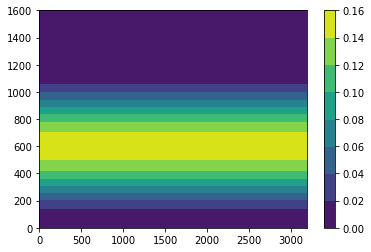

In [52]:
#plt.contourf(X,Y,taux.transpose())
#plt.colorbar()

plt.contourf(X,Y,taux)
plt.colorbar()

#plt.plot(Y, tau_0*np.sin(np.pi*Y/LENLAT)**2)
#plt.plot(Y, tau_0*np.sin(2*np.pi*Y/LENLAT))

(400, 800)
(400, 800)
1.603810890548638e-28
1.603810890548638e-28
0.0
-3.6739403974420595e-17


0.0

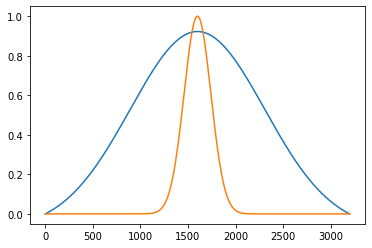

In [20]:
print(taux.shape)
print(depth.shape)
#Ym.shape
#Xm

a = tau_0*np.sin(2*np.pi*Y/LENLAT)
#np.sum(a)

ridge1 = np.exp(-((X - LENLON/2)/1000.)**2) 
ridge1 = ridge1 - np.min(ridge1)
ridge2 = np.exp(-((X - LENLON/2)/200.)**2)
plt.plot(X,ridge1)
plt.plot(X, ridge2)
print(ridge2[0])
print(ridge2[-1])

print(a[0])
print(a[-1])
np.sum(a)


In [48]:
# Save data to nc file
ds = xr.Dataset(
        data_vars={'taux':    (('lat', 'lon'), taux),
                   'tauy': (('lat', 'lon'), tauy),
                   'depth':    (('lat', 'lon'), depth),
                  'h': (('level', 'lat', 'lon'), h),
                  'eta': (('interface','lat', 'lon'), eta)},
        coords={'lat': Y, 'lon': X, 'depth_list': eta0, 'level': density})

ds.lat.attrs['units'] = 'km'
ds.lon.attrs['units'] = 'km'
ds.depth_list.attrs['units'] = 'm'
ds.level.attrs['units'] = 'kg m-3'
ds.depth.attrs['units'] = 'm'
ds.taux.attrs['units'] = 'N m-2'
ds.tauy.attrs['units'] = 'N m-2'
ds.h.attrs['units'] = 'm'
ds.eta.attrs['units'] = 'm'

ds.lon.attrs['standard_name'] = 'Longitude'
ds.lat.attrs['standard_name'] = 'Latitude'
ds.depth_list.attrs['standard_name'] = 'Mean Interface Height'
ds.level.attrs['standard_name'] = 'Mean Layer Density'
ds.depth.attrs['standard_name'] = 'Total Depth'
ds.taux.attrs['standard_name'] = 'Zonal Wind Stress'
ds.tauy.attrs['standard_name'] = 'Meridional Wind Stress'
ds.h.attrs['standard_name'] = 'Layer Depth'
ds.eta.attrs['standard_name'] = 'Interface Height'

ds.to_netcdf(path='/home/Hemant.Khatri/Work/Navid_input.nc')

In [49]:
ds

<xarray.Dataset>
Dimensions:     (depth_list: 3, interface: 3, lat: 400, level: 2, lon: 800)
Coordinates:
  * lat         (lat) float64 0.0 4.01 8.02 ... 1.592e+03 1.596e+03 1.6e+03
  * lon         (lon) float64 0.0 4.005 8.01 ... 3.192e+03 3.196e+03 3.2e+03
  * depth_list  (depth_list) float64 0.0 -2e+03 -4e+03
  * level       (level) float64 1.031e+03 1.031e+03
Dimensions without coordinates: interface
Data variables:
    taux        (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tauy        (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    depth       (lat, lon) float64 4e+03 4e+03 4e+03 4e+03 ... 4e+03 4e+03 4e+03
    h           (level, lat, lon) float64 1e+03 1e+03 1e+03 ... 3e+03 3e+03
    eta         (interface, lat, lon) float64 0.0 0.0 0.0 ... -4e+03 -4e+03

In [10]:
# Baroclinic Rossby deformation radius
rho1, rho2 = (1027.35, 1027.9)
H1, H2 = (1000., 3000.)
fo = 10**-4
gp = 9.8*(rho2-rho1)/rho1

Rd = np.sqrt(gp*H1*H2/(H1+H2))/fo

print(gp, Rd)



0.00524650800603668 19836.53448697002


In [43]:
np.round(3*LENLAT/(4*NJ))

3.0